# 1. Quantlib Basics

In [14]:
from QuantLib import *

In [2]:
date = Date(31, 3, 2015)
print(date)

March 31st, 2015


In [4]:
print ("%d-%d-%d" %(date.month(), date.dayOfMonth(), date.year()))

3-31-2015


In [5]:
 date.weekday() == Tuesday

True

Математические операции с датами

In [3]:
print ("Add a day : ", date + 1)
print ("Subtract a day : ", date - 1)
print ("Add a week : ", date + Period(1, Weeks))
print ("Add a month : ", date + Period(1, Months))
print ("Add a year : ", date + Period(1, Years))

Add a day :  April 1st, 2015
Subtract a day :  March 30th, 2015
Add a week :  April 7th, 2015
Add a month :  April 30th, 2015
Add a year :  March 31st, 2016


Сравнение дат

In [4]:
print (date == Date(31, 3, 2015))
print (date > Date(30, 3, 2015))
print (date < Date(1, 4, 2015))
print (date != Date(1, 4, 2015))


True
True
True
True


Использование календаря (берет в расчет праздники в зависимости от страны)

In [15]:
date = Date(31, 3, 2015)
us_calendar = UnitedStates()
italy_calendar = Italy()

period = Period(60, Days)
raw_date = date + period
us_date = us_calendar.advance(date, period)
italy_date = italy_calendar.advance(date, period)

print ("Add 60 days:", raw_date)
print ("Add 60 business days in US:", us_date)
print ("Add 60 business days in Italy:", italy_date)


Add 60 days: May 30th, 2015
Add 60 business days in US: June 24th, 2015
Add 60 business days in Italy: June 26th, 2015


In [6]:
us_busdays = us_calendar.businessDaysBetween(date, us_date)
italy_busdays = italy_calendar.businessDaysBetween(date, italy_date)

print ("Business days US:", us_busdays)
print ("Business days Italy:", italy_busdays)

Business days US: 60
Business days Italy: 60


Совмещение календарей

In [7]:
joint_calendar = JointCalendar(us_calendar, italy_calendar)
joint_date = joint_calendar.advance(date, period)
joint_busdays = joint_calendar.businessDaysBetween(date, joint_date)

print ("Add 60 business days in US-Italy:", joint_date)
print ("Business days US-Italy:", joint_busdays)

Add 60 business days in US-Italy: June 29th, 2015
Business days US-Italy: 60


Расписание

In [8]:
effective_date = Date(1, 1, 2015)
termination_date = Date(1, 1, 2016)
tenor = Period(Monthly)
calendar = UnitedStates()
business_convention = Following
termination_business_convention = Following
date_generation = DateGeneration.Forward
end_of_month = False

schedule = Schedule(effective_date, termination_date, tenor, calendar, business_convention, termination_business_convention, date_generation, 
end_of_month)
for i, d in enumerate(schedule):
    print (i+1, d)

1 January 2nd, 2015
2 February 2nd, 2015
3 March 2nd, 2015
4 April 1st, 2015
5 May 1st, 2015
6 June 1st, 2015
7 July 1st, 2015
8 August 3rd, 2015
9 September 1st, 2015
10 October 1st, 2015
11 November 2nd, 2015
12 December 1st, 2015
13 January 4th, 2016


The InterestRate class can be used to store the interest rate with the compounding type, day
count and the frequency of compounding. Below we show how to create an interest rate of 5.0%
compounded annually, using Actual/Actual day count convention

In [9]:
annual_rate = 0.05
day_count = ActualActual()
compound_type = Compounded
frequency = Annual

interest_rate = InterestRate(annual_rate, day_count, compound_type, frequency)

Lets say if you invest a dollar at the interest rate described by interest_rate, the compoundFactor
method in the InterestRate object gives you how much your investment will be worth after any
period. Below we show that the value returned by compound_factor for 2 years agrees with the
expected compounding formula

In [10]:
t = 2.0

print (interest_rate.compoundFactor(t))
print ((1+annual_rate)*(1.0+annual_rate))

1.1025
1.1025


The discountFactor method returns the reciprocal of the compoundFactor method. The discount
factor is useful while calculating the present value of future cashflows

In [11]:
print (interest_rate.discountFactor(t))
print (1.0/interest_rate.compoundFactor(t))

0.9070294784580498
0.9070294784580498


# 2. Instruments and pricing engines

In [16]:
today = Date(7, March, 2014)
Settings.instance().evaluationDate = today

As a sample instrument, we’ll take a textbook example: a European option.
Building the option requires only the specification of its contract, so its payoff (it’s a call option
with strike at 100) and its exercise, three months from today’s date. Market data will be selected and
passed later, depending on the calculation methods

In [17]:
option = EuropeanOption(PlainVanillaPayoff(Option.Call, 100.0), EuropeanExercise(Date(7, June, 2014)))

**First pricing method: analytic Black-Scholes formula** 
https://habr.com/ru/post/552194/ SimpleQuote instances: those model numbers whose value can change and that can notify observers when this happens. The underlying value is at 100, the risk-free value at 1%,
and the volatility at 20%.

In [18]:
u = SimpleQuote(100.0)
r = SimpleQuote(0.01)
sigma = SimpleQuote(0.20)

First
we build flat curves for the risk-free rate and the volatility

In [19]:
riskFreeCurve = FlatForward(0, TARGET(), QuoteHandle(r), Actual360())
volatility = BlackConstantVol(0, TARGET(), QuoteHandle(sigma), Actual360())

…then we instantiate the process with the underlying value and the curves we just built. The inputs
are all stored into handles, so that we could change the quotes and curves used if we wanted

In [20]:
process = BlackScholesProcess(QuoteHandle(u), YieldTermStructureHandle(riskFreeCurve), BlackVolTermStructureHandle(volatility))

build the engine

In [21]:
engine = AnalyticEuropeanEngine(process)

and once we have the engine, we can set it to the option and evaluate the latter

In [22]:
 option.setPricingEngine(engine)
 print (option.NPV())

4.155543462156206


**Market changes** Market data are stored in Quote instances and thus can notify the option when any
of them changes.

In [23]:
u.setValue(105.0)
print (option.NPV())

7.27556357927846


Just for showing off, we can use this to graph the option value depending on the underlying asset
value. After a bit of graphic setup (don’t pay attention to the man behind the curtains)

In [28]:
%%capture
%pylab inline --no-import-all
import matplotlib.pyplot as plot
from matplotlib.pyplot import figure
import numpy
from IPython.display import display
import utils
# utils.set_default_plot_size()

We can take an array of values from 80 to 120, set the underlying value to each of them, collect the
corresponding option values, and plot the results

<Figure size 4000x4000 with 0 Axes>

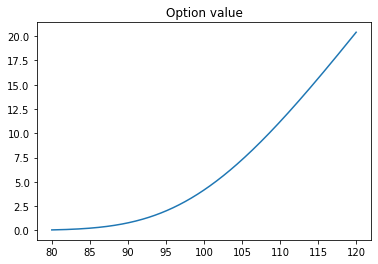

In [33]:
figure(figsize=(40, 40), dpi=100)
f, ax = plot.subplots()
xs = numpy.linspace(80.0, 120.0, 400)
ys = []
for x in xs:
    u.setValue(x)
    ys.append(option.NPV())
ax.set_title('Option value')
_ = ax.plot(xs, ys)


**Date changes** Just as it does when inputs are modified, the value also changes if we advance the evaluation date

**Other pricing methods** Heston model

In [35]:
Settings.instance().evaluationDate = today
u.setValue(105.0)
r.setValue(0.01)
sigma.setValue(0.20)

In [36]:
print (option.NPV())

7.27556357927846


Let’s say that we want to use a Heston model to price the option. What we have to do is to instantiate
the corresponding class with the desired inputs

In [37]:
model = HestonModel(HestonProcess(YieldTermStructureHandle(riskFreeCurve), YieldTermStructureHandle(FlatForward(0, TARGET(), 0.0, Actual360())), QuoteHandle(u), 0.04, 0.1, 0.01, 0.05, -0.75))

Pass it to the corresponding engine, and set the new engine to the option

In [38]:
engine = AnalyticHestonEngine(model)
option.setPricingEngine(engine)

Asking the option for its NPV will now return the value according to the new model.

In [39]:
print (option.NPV())

7.295356086978643


**Monte Carlo engine**

In [40]:
engine = MCEuropeanEngine(process, "PseudoRandom",
timeSteps=20,
requiredSamples=250000)
option.setPricingEngine(engine)

In [42]:
%time 
print (option.NPV())

7.282505515617214
CPU times: total: 0 ns
Wall time: 0 ns


# 3. Numerical Greeks calculation

In this notebook, I’ll build on the facilities provided by the Instrument class (that is, its ability to
detect changes in its inputs and recalculate accordingly) to show how to calculate numerical Greeks
when the engine doesn’t provide them.

In [ ]:
today = Date(8, October, 2014)
Settings.instance().evaluationDate = today

As an example, we’ll use a knock-in barrier option

In [43]:
option = BarrierOption(Barrier.UpIn,
120.0, # barrier
0.0, # rebate
PlainVanillaPayoff(Option.Call, 100.0),
EuropeanExercise(Date(8, January, 2015)))

In [44]:
u = SimpleQuote(100.0)
r = SimpleQuote(0.01)
sigma = SimpleQuote(0.20)

In [45]:
riskFreeCurve = FlatForward(0, TARGET(), QuoteHandle(r), Actual360())
volatility = BlackConstantVol(0, TARGET(), QuoteHandle(sigma), Actual360())

In [46]:
process = BlackScholesProcess(QuoteHandle(u),
YieldTermStructureHandle(riskFreeCurve),
BlackVolTermStructureHandle(volatility))

Finally, we build the engine (the library provides one based on an analytic formula) and set it to the
option

In [48]:
option.setPricingEngine(AnalyticBarrierEngine(process))

In [49]:
print (option.NPV())

6.4389123445265355


The engine doesn’t provide the delta, so asking for it raises an error.

In [ ]:
print (option.delta())

**Numerical calculation** We can use numerical differentiation to approximate the Greeks, as
shown in the next figure: that is, we can approximate the derivative by calculating the option value
for two slightly different values of the underlying and by taking the slope between the resulting
points.

In [50]:
u0 = u.value() ; h = 0.01
P0 = option.NPV()
print (P0)

6.4389123445265355


In [51]:
u.setValue(u0+h)
P_plus = option.NPV()
print (P_plus)

6.444512644827632


In [52]:
u.setValue(u0-h)
P_minus = option.NPV()
print (P_minus)

6.433314926844804


In [53]:
u.setValue(u0)

In [54]:
Delta = (P_plus - P_minus)/(2*h)
Gamma = (P_plus - 2*P0 + P_minus)/(h*h)
print (Delta)
print (Gamma)


0.5598858991413991
0.028826193645414833


In [56]:
r0 = r.value() ; h = 0.0001
r.setValue(r0+h) ; P_plus = option.NPV()
r.setValue(r0)
Rho = (P_plus - P0)/h
print (Rho)

38.45132738684143


In [57]:
sigma0 = sigma.value() ; h = 0.0001
sigma.setValue(sigma0+h) ; P_plus = option.NPV()
sigma.setValue(sigma0)
Vega = (P_plus - P0)/h
print (Vega)

49.538840456015976


In [58]:
Settings.instance().evaluationDate = today+1
P1 = option.NPV()
h = 1.0/365
Theta = (P1-P0)/h
print (Theta)

-19.109452235594322


# 4. Market quotes

In this notebook, I’ll show a pitfall to avoid when multiple quotes need to be updated

In [59]:
today = Date(17, October, 2016)
Settings.instance().evaluationDate = today

I’ll create a bond curve

In [60]:
data = [ (2, 0.02), (4, 0.0225), (6, 0.025), (8, 0.0275),
(10, 0.03), (12, 0.0325), (14, 0.035), (16, 0.0375),
(18, 0.04), (20, 0.0425), (22, 0.045), (24, 0.0475),
(26, 0.05), (28, 0.0525), (30, 0.055)]

For simplicity, I’ll use the same start date, frequency and conventions for all the bonds; this doesn’t
affect the point I’m going to make in the rest of the notebook. I’ll also assume that all bonds currently
price at 100. I’ll skip over the details of building the curve now; the one thing you’ll need to remember
is that it depends on the quotes modeling the bond prices

In [61]:
calendar = TARGET()
settlement = calendar.advance(today, 3, Days)
quotes = []
helpers = []
for length, coupon in data:
    maturity = calendar.advance(settlement, length, Years)
    schedule = Schedule(settlement, maturity, Period(Annual),
                        calendar, ModifiedFollowing, ModifiedFollowing,
                        DateGeneration.Backward, False)
    quote = SimpleQuote(100.0)
    quotes.append(quote)
    helpers.append(FixedRateBondHelper(QuoteHandle(quote), 3, 100.0,
                    schedule, [coupon], SimpleDayCounter(),
                    ModifiedFollowing))
curve = FittedBondDiscountCurve(0, calendar, helpers,
SimpleDayCounter(), NelsonSiegelFitting())

A visualization of the curve as discount factors versus time in years

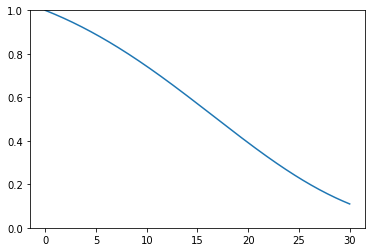

In [62]:
sample_times = numpy.linspace(0.0, 30.0, 301)
sample_discounts = [ curve.discount(t) for t in sample_times ]
f, ax = plot.subplots()
ax.set_ylim(0.0, 1.0)
_ = ax.plot(sample_times, sample_discounts)

Also, here’s a bond priced by discounting its coupons on the curve

In [63]:
schedule = Schedule(today, calendar.advance(today, 15, Years),
Period(Semiannual), calendar,
ModifiedFollowing, ModifiedFollowing,
DateGeneration.Backward, False)
bond = FixedRateBond(3, 100.0, schedule, [0.04], Actual360())
bond.setPricingEngine(DiscountingBondEngine(YieldTermStructureHandle(curve)))

print (bond.cleanPrice())

105.77449622178025
